<h1 style = "color:blue"> Customer Churn Analysis – Telecom Industry</h1>

## Executive Summary
This project aims to analyze customer churn behavior in a telecom company and build a predictive model to identify customers likely to churn. The insights generated will support proactive retention strategies and revenue protection.


## 1. Business Problem & Objective

### 1.1 What is Customer Churn?
Customer churn refers to customers who discontinue using a company’s product or service within a given time period.

In this telecom context:
- **Churn = customer cancels their subscription**
- **Target Variable:** `Churn` (Yes / No)

---

### 1.2 Why Churn Matters
Customer churn has a direct impact on business performance:
- Acquiring new customers is significantly more expensive than retaining existing ones
- High churn leads to reduced revenue, customer lifetime value (CLV), and market share
- Predicting churn enables proactive retention strategies, personalized offers, and improved customer experience

---

### 1.3 Business Objective
The objective of this project is to build a **classification model** that predicts whether a customer is likely to churn, enabling the business to take early retention actions.


<h2>2. Data Understanding & Initial Inspection</h2>

In [5]:
#Importing the necessarry Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid")


In [6]:
df = pd.read_csv("/Telco-Customer-Churn.csv")

In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Dataset Overview
- Each row represents a unique customer
- The dataset contains demographic information, service usage, billing details, and churn status
- The target variable `Churn` is categorical (Yes / No)


<h3>Identifing Feature Types</h3>

In [9]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


### Feature Types
- **Numerical features:** tenure, MonthlyCharges, TotalCharges
- **Categorical features:** Contract, PaymentMethod, InternetService, etc.
- **Identifier column:** customerID (not useful for modeling)


<h2>3. Data Cleaning & Preparation</h2>

In [10]:
#Checking for missing values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [11]:
# Checking to confirm the data type of the TotalCharges column
df['TotalCharges'].dtype
df['TotalCharges'].apply(type).value_counts()

,count
TotalCharges,
<class 'str'>,7043


In [12]:
# Converting the strings to numric float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='raise')

ValueError: Unable to parse string " " at position 488

Converting object string to float is raising concerns meaning there is blank space in TotalCharges,
which is not a NAN, that was why checking for missing values showed 0 missing.

In [13]:
# Fixing the blank space problem by replacing it with NaN
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

In [14]:
#Checking for missing values in TotalCharges column again for confirmation
df['TotalCharges'].isnull().sum()


np.int64(11)

In [15]:
#Converting string to numeric float again
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [16]:
# Replacing the NaN values with the median of the entire TotalCharges column
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


In [17]:
df['TotalCharges'].dtype
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


#### Missing values in `TotalCharges` were caused by customers with extremely short tenure have not yet accumulated any charges.The median was used to avoid skewing the distribution.

In [18]:
# Encoding target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [19]:
#Dropping the customerID column
df.drop('customerID', axis=1, inplace=True)


In [20]:
# Validating target variable to check for class balance
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.73463
1,0.26537


### Churn Distribution
Approximately 26–27% of customers have churned.
This indicates a moderately imbalanced dataset, making accuracy alone an unreliable evaluation metric.
Recall,  Precision, F1-score, ROC-AUC will be prioritized.


<h2> 4. Exploratory Data Analysis </h2>

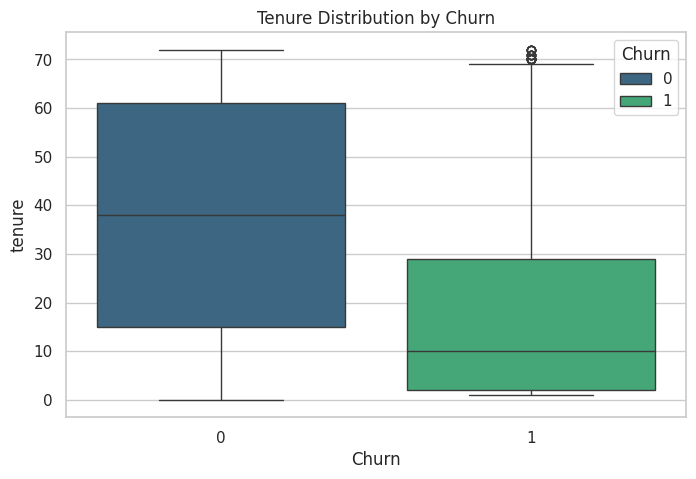

In [21]:
#Boxplot of Churn vrs Tenure
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='tenure', data=df, hue='Churn', palette ='viridis')
plt.title("Tenure Distribution by Churn")
plt.show()


Customers who churn typically have significantly shorter tenure, indicating that early-stage customers are at higher risk.

Text(0.5, 0, 'Tenure (Months)')

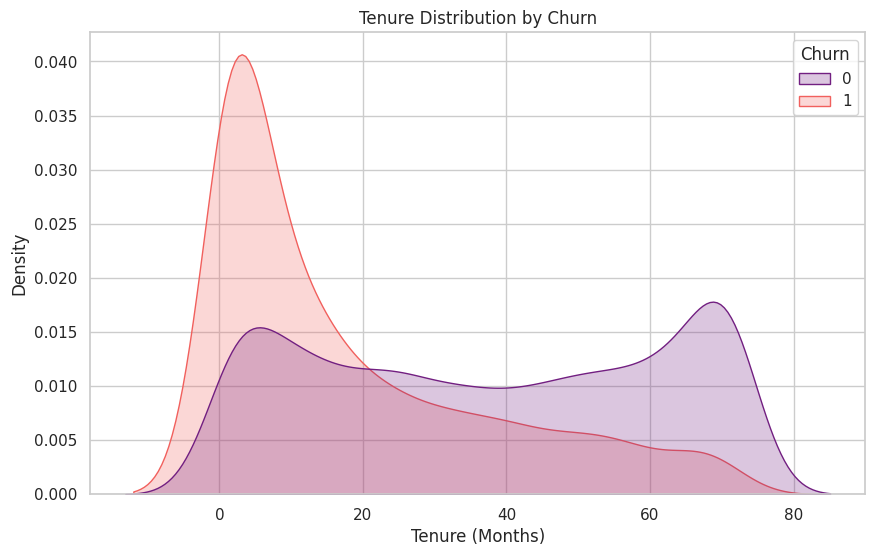

In [22]:
# Visualization 2: Tenure vs Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False, palette='magma')
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')

Customers on month-to-month contracts churn at significantly higher rates compared to long-term contracts.


Text(0.5, 1.0, 'Churn by Contract Type')

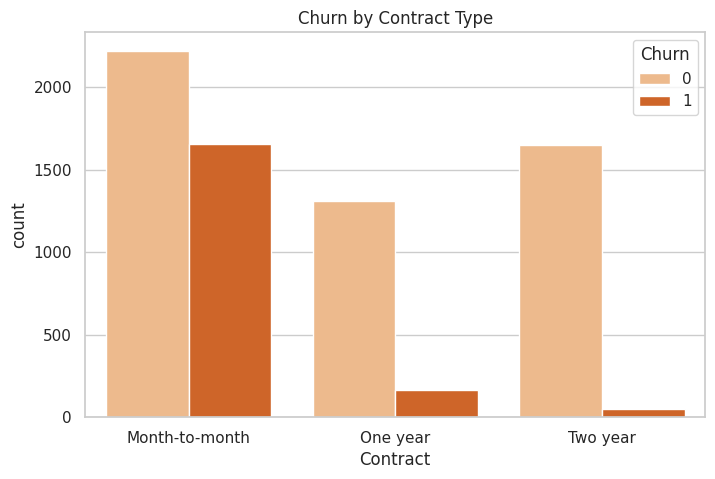

In [23]:
# Visualization 3: Contract Type vs Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Contract', hue='Churn', palette='Oranges')
plt.title('Churn by Contract Type')

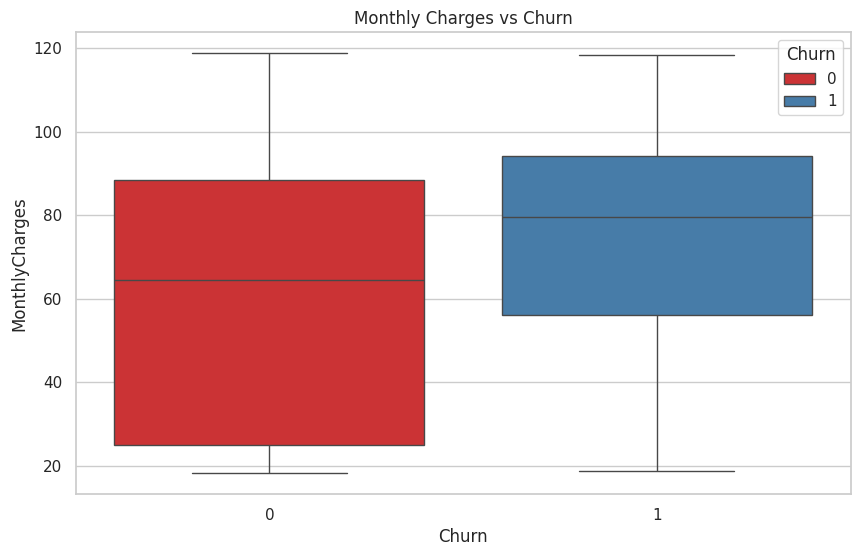

In [24]:
# Visualization 4: Monthly Charges vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', hue='Churn', palette='Set1')
plt.title('Monthly Charges vs Churn')
plt.savefig('monthly_charges_boxplot.png')

<h2> 5. Feature Engineering</h2>

Tenure grouping captures customer lifecycle stages and improves interpretability.

# Create Tenure Groups

In [25]:
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 72],
    labels=['0-12 months', '12-24 months', '24+ months']
)

In [26]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-12 months
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,24+ months
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-12 months
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,24+ months
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-12 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,12-24 months
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,24+ months
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0-12 months
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1,0-12 months


### 5.1 Encoding Categorical Varaibles

In [27]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [28]:
df_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_12-24 months,tenure_group_24+ months
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,True,False,True,False,False,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,True,False,False,False,False,True,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,True,False,False,True,False,False
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,True,False,True,False,False,False


Categorical variables were converted into numerical format using one-hot encoding. To avoid multicollinearity, the first category of each variable was dropped, resulting in a reduced and more stable feature set.

In [29]:
df_encoded.shape

(7043, 33)

In [30]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Stratification ensures churn distribution remains consistent across splits.

In [31]:
# 6.2 Scaling (Essential for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Modelling

In [32]:
# MODEL 1: Logistic Regression (Baseline)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

In [33]:
# MODEL 2: Random Forest (Advanced)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # Tree models don't need scaling
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

## 6. Churn Modelling

Two models were trained to predict customer churn:

### 6.1 Baseline Model – Logistic Regression
Logistic Regression was selected as the baseline model because:
- It is highly interpretable and easy to explain to business stakeholders
- Coefficients provide insight into the direction of feature influence
- It establishes a performance benchmark for more complex models

### 6.2 Advanced Model – Random Forest
A Random Forest classifier was trained to capture:
- Non-linear relationships
- Feature interactions that Logistic Regression may miss

**Trade-off:**
- Logistic Regression offers higher interpretability
- Random Forest typically offers better performance but reduced explainability


# 7. Model Evaluation

In [34]:
# 7. Evaluation
# Logistic Regression Report
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

ROC-AUC: 0.8414709757420754


In [35]:
# Random Forest Report
print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC: 0.8265635898628225


### 7.2 Evaluation Metrics Explanation

#### Accuracy
While both models achieve ~79–80% accuracy, this metric is misleading due to class imbalance.
Predicting all customers as non-churn would still yield high accuracy.

#### Precision (Churn Class = 1)
Precision reflects cost efficiency:
- Logistic Regression: 0.66
- Random Forest: 0.64

This means ~64–66% of customers flagged as churners actually churned.

#### Recall (Churn Class = 1)
Recall is the most important metric for churn:
- Logistic Regression: **0.53**
- Random Forest: **0.50**

This indicates that roughly half of churners are successfully identified.
From a business perspective, increasing recall directly reduces customer loss.

#### ROC-AUC
- Logistic Regression: **0.84**
- Random Forest: **0.83**

Both models demonstrate strong overall discriminatory power.
Logistic Regression slightly outperforms Random Forest in this case.


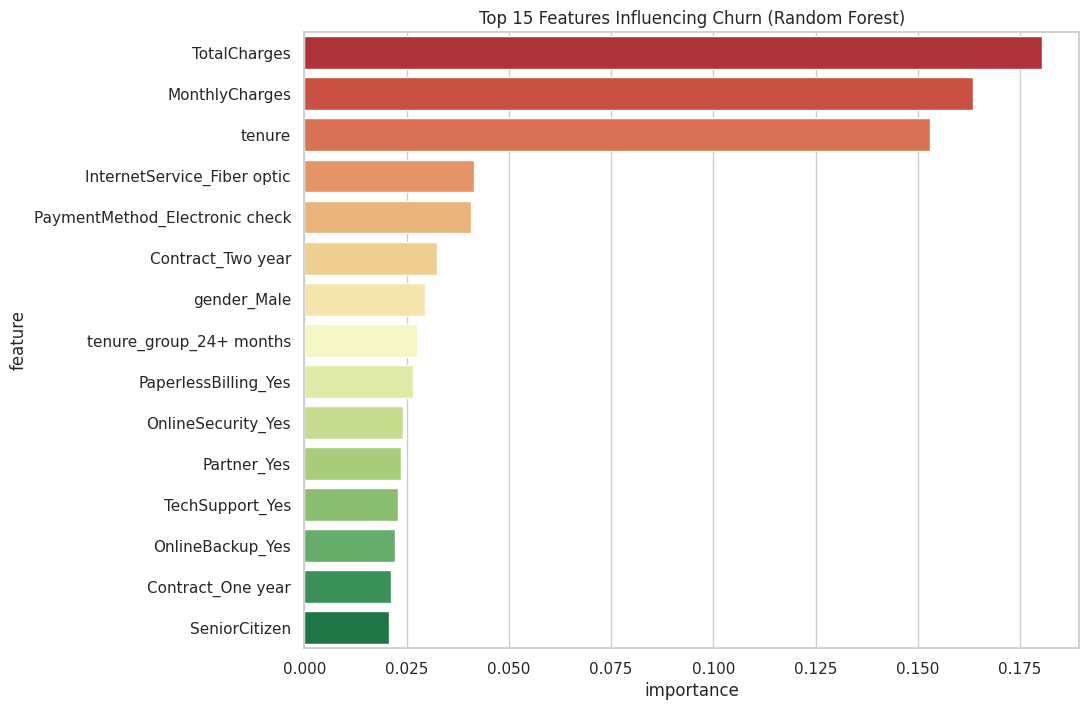

In [36]:
# Feature Importance (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature',hue='feature', palette='RdYlGn')
plt.title('Top 15 Features Influencing Churn (Random Forest)')
plt.savefig('feature_importance.png')

Stage 2 Results:
(7043, 21)
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


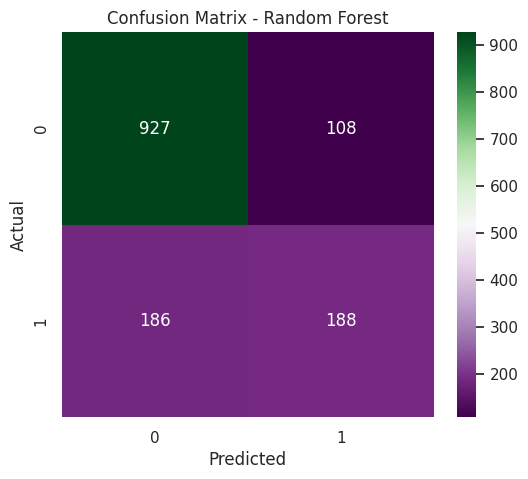

In [37]:
# Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='PRGn')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print("Stage 2 Results:")
print(df.shape)
print(df['Churn'].value_counts(normalize=True))

### 7.3 Confusion Matrix Interpretation (Random Forest)

- **True Positives (TP):** Correctly identified churned customers
- **False Positives (FP):** Customers predicted to churn but did not  
  → Leads to unnecessary retention costs
- **False Negatives (FN):** Customers who churned but were not identified  
  → Represents lost revenue and missed intervention opportunities

In churn prediction, **False Negatives are more costly than False Positives** because losing a customer is more expensive than offering an unnecessary incentive.
Therefore, recall is prioritized over precision.

### Model Selection Insight
Although Random Forest is more complex, Logistic Regression performs slightly better on ROC-AUC and recall.
This suggests churn drivers in this dataset are largely linear and interpretable.

### Evaluation Metrics Insights

- **Accuracy:** Can be misleading due to class imbalance
- **Precision:** Important to control unnecessary retention spend
- **Recall:** Critical for identifying at-risk customers before they churn
- **ROC-AUC:** Measures overall model discrimination across thresholds

For churn prediction, **recall for churned customers is the most important metric**.


# 8. Postdictive Analysis

## Now we analyze where the model succeeds and fails.

In [38]:
# Postdictive Analysis
X_test_copy = X_test.copy()
X_test_copy['Actual'] = y_test
X_test_copy['Predicted'] = y_pred_lr

# Identify False Negatives (Predicted 0, but actually 1)
false_negatives = X_test_copy[(X_test_copy['Actual'] == 1) & (X_test_copy['Predicted'] == 0)]
# Identify False Positives (Predicted 1, but actually 0)
false_positives = X_test_copy[(X_test_copy['Actual'] == 0) & (X_test_copy['Predicted'] == 1)]

print(f"Number of False Negatives (Lost customers missed): {len(false_negatives)}")
print(f"Number of False Positives (Unnecessary retention spend): {len(false_positives)}")

# Analyze False Negatives - where does it fail?
print("\nMean tenure for False Negatives:", false_negatives['tenure'].mean())
print("Mean tenure for overall churners:", df[df['Churn'] == 1]['tenure'].mean())


Number of False Negatives (Lost customers missed): 174
Number of False Positives (Unnecessary retention spend): 104

Mean tenure for False Negatives: 24.99425287356322
Mean tenure for overall churners: 17.979133226324237


### Postdictive Analysis Insights

The postdictive analysis compares predicted churn outcomes against actual churn behavior.

- **False Negatives:** Customers who churned but were not identified by the model
- **False Positives:** Customers incorrectly flagged as churn risks.


False negatives tend to have higher average tenure compared to early-stage churners.
This suggests the model struggles to detect churn among long-tenure customers whose behavior deviates subtly rather than abruptly.



### Where the Model Performs Well
- Short-tenure customers with high monthly charges
- Customers on month-to-month contracts
- Customers with limited service bundles

These patterns align strongly with EDA findings, reinforcing model reliability in these segments.


### Model Limitations

The model struggles in the following scenarios:
- Long-tenure customers with stable historical behavior
- Customers whose churn is influenced by external or unobserved factors
- Lack of behavioral signals such as customer support interactions or service quality metrics

These limitations suggest that incorporating behavioral and temporal features could further improve performance.


## Final Assessment on Model

Overall, the models demonstrate strong discriminatory power but moderate recall for churned customers.
This reflects real-world churn complexity and highlights opportunities for further optimization through threshold tuning, cost-sensitive learning, and additional behavioral data.


# 9. Business Recommendations

Based on exploratory analysis and model predictions, the following customer segments should be prioritized for churn mitigation:


### 9.1 Priority Customer Segments

1. **High Churn Probability Customers**
   - Customers predicted with high churn probability by the model
   - Represent the most immediate risk to revenue

2. **High-Value Customers**
   - Customers with high monthly charges and multiple subscribed services
   - Churn in this segment results in disproportionate revenue loss

3. **Short-Tenure, High-Charge Customers**
   - Customers within their first 12 months
   - Typically on month-to-month contracts
   - Exhibit price sensitivity and low switching costs


### 9.2 Recommended Retention Actions

To reduce churn within the identified segments, the following actions are recommended:


1. **Contract Upgrade Incentives**
   - Offer discounts or benefits for transitioning from month-to-month to long-term contracts
   - Particularly effective for early-tenure customers

2. **Targeted Loyalty Discounts**
   - Apply retention offers selectively to high-risk, high-value customers
   - Avoid blanket discounts to control costs

3. **Enhanced Onboarding Programs**
   - Provide structured onboarding for new customers within the first 90 days
   - Improve early engagement and perceived value

4. **Service Bundling**
   - Encourage adoption of multiple services (internet, streaming, security)
   - Increases switching costs and customer stickiness


### 9.3 Estimated Business Impact

Assumptions:
- Current churn rate: ~26%
- Targeted intervention group: Top 20% highest-risk customers
- Expected churn reduction in this group: 15–20%


Estimated outcomes:
- Overall churn reduction: ~3–5 percentage points
- Improved customer lifetime value (CLV)
- Reduced acquisition costs due to higher retention

Although retention initiatives incur costs (discounts, support, onboarding),
these costs are significantly lower than the revenue lost from customer churn.


## Project Structure Summary

The Jupyter Notebook is organized as follows:
1. Executive Summary
2. Business Problem Definition
3. Data Preparation & Cleaning
4. Exploratory Data Analysis (EDA)
5. Feature Engineering
6. Churn Modeling
7. Model Evaluation
8. Postdictive Analysis
9. Insights & Business Recommendations


## Final Remarks

This project demonstrates a structured, business-aligned approach to churn analysis.
Rather than focusing on complex algorithms, the emphasis is placed on:
- Clear problem framing
- Interpretable models
- Actionable insights
- Practical business recommendations

Such an approach ensures that machine learning outputs translate into real business value.
